In [1]:
import os, glob, pickle
import scipy.io as sio
import numpy as np
import pandas as pd
import pickle, sys
from scipy.optimize import linear_sum_assignment
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [8]:
path = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(path) 

saving_folder = path + '/results/cpl_mixVAE/cluster_analysis'

In [2]:
n_run = 1
n_categories = 120
state_dim = 2
n_arm = 2
tau = .005
beta = 1
fc_dim = 100
latent_dim = 10
lr = 0.001
p_drop = .5
n_gene = 5023
batch_size = 5000
n_epoch = 10000
n_epoch_p = 1000
n_gene = 5000
device = None
augmentation = True
ref_prior = False

path = os.getcwd()
data_path = path + '/data/Mouse-V1-ALM-20180520_cpmtop10k_cpm_withCL.mat'
folder_name = f'run_{n_run}_K_{n_categories}_Sdim_{state_dim}_p_drop_{p_drop}_fc_dim_{fc_dim}_Prior_{ref_prior}_aug_{augmentation}' + \
    f'_lr_{lr}_n_arm_{n_arm}_tau_{tau}_temp_1_beta_{beta}_nbatch_{batch_size}_nepoch_{n_epoch}_nepochP_{n_epoch_p}'
saving_folder = path + "/results/cplmixVAE/"
saving_folder = saving_folder + str(folder_name)
models = glob.glob(saving_folder + '/model/cpl_mixVAE_model_*')
print(len(models))
saving_folder

43


'/Users/yeganeh.marghi/github/cplmixVAE_facs/results/cplmixVAE/run_1_K_120_Sdim_2_p_drop_0.5_fc_dim_100_Prior_False_aug_True_lr_0.001_n_arm_2_tau_0.005_temp_1_beta_1_nbatch_5000_nepoch_10000_nepochP_1000'

In [3]:
model_order = 92
selected_model = glob.glob(saving_folder + '/model/cpl_mixVAE_model_after_pruning_' + str(n_categories - model_order) + '*')[0]
cpl_mixVAE, data, outcome = eval_mixmodel(n_categories=n_categories, 
                                       state_dim=state_dim, 
                                       n_arm=n_arm,
                                       latent_dim=latent_dim,
                                       fc_dim=fc_dim,
                                       tau=tau,
                                       n_gene=n_gene,
                                       saving_folder=saving_folder, 
                                       data_file=data_path,
                                       ref_pc=ref_prior,
                                       all_data=True,
                                       device=device,
                                       models=[selected_model]) 

using CPU ...
/Users/yeganeh.marghi/github/cplmixVAE_facs/results/cplmixVAE/run_1_K_120_Sdim_2_p_drop_0.5_fc_dim_100_Prior_False_aug_True_lr_0.001_n_arm_2_tau_0.005_temp_1_beta_1_nbatch_5000_nepoch_10000_nepochP_1000/model/model_eval


In [4]:
label_T = data['cluster']
htree_file = path + "/data/tree.csv" 
data['cluster'] = np.array([c.strip() for c in data['cluster']])
T_class = np.unique(data['cluster'])
n_cluster = len(T_class)
merged_cells_labels, treeobj, _ = get_merged_types(htree_file=htree_file, cells_labels=data['cluster'], num_classes=1)
idd = []
for i, s in enumerate(treeobj.child):
    s = s.strip()
    if (T_class == s).any():
        cluster_id = list(T_class).index(s)
        idd.append(cluster_id)
        
T_class_ord = T_class[idd]
print(len(T_class_ord))

row_sort_T = []
for s in T_class_ord:
    row_sort_T.append(list(T_class).index(s))

row_sort_T = np.array(row_sort_T)

115


/Users/yeganeh.marghi/miniconda3/envs/tf14-cpu/lib/python3.7/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [5]:
tp = np.array(list(data['cluster']))
_, treeobj_1, _ = get_merged_types(htree_file=htree_file, cells_labels=tp, num_classes=1, ref_leaf=T_class_ord)
ref_parent = treeobj_1.parent
ref_leaf = treeobj_1.child

len_merg_class = 0
mm = 1

while(len_merg_class != model_order):
    _, treeobj, _ = get_merged_types(htree_file=htree_file, cells_labels=tp, num_classes=mm, ref_leaf=T_class_ord)
    leaf_nodes = treeobj.child[treeobj.isleaf]
    merged_clusters = np.copy(T_class)
    tmp = []

    for n, node in enumerate(leaf_nodes):
        if node[0] == 'n':
            l_node = ref_leaf[node == ref_parent]
            review_node = True
            go = 0

            while review_node:
                new_node = []
                for l_n in l_node:
                    if l_n[0] == 'n':
                        new_node.append(ref_leaf[l_n == ref_parent])
                    else:
                        new_node.append(l_n)

                go += 1
                l_node = np.hstack(new_node)
                if go > 10:
                    review_node = False

            tmp.append(l_node)
        else:
            tmp.append(node)

        for l_n in tmp[-1]:
            try:
                merged_clusters[l_n == T_class] = node
            except:
                continue
                
    len_merg_class = len(np.unique(merged_clusters))
    mm += 1

print(model_order, len(np.unique(merged_clusters)), mm)

merg_T_clusters = np.copy(data['cluster'])

for c, mc in zip(T_class, merged_clusters):
    merg_T_clusters[data['cluster'] == c] = mc

92 92 25


In [40]:
K_fold = 10
n_type = 42
model_order = 30
n_arm = 2
n_PCs = 100
z_dim = 30


acc_T_lowD = []
acc_merged_T_lowD = []
acc_cons_lowD = []

sc_T_lowD = []
sc_mergT_lowD = []
sc_cons_lowD = []

conf_T_lowD = []
conf_mergT_lowD = []
conf_cons_lowD = []

data_file_id = saving_folder + f"/Ttype_classification_K_{n_type}_nFeature_{n_PCs}.p" 
sum_dict = pickle.load(open(data_file_id, "rb")) 
acc_T_pc = sum_dict['acc_T_adj']
sc_T_pc = sum_dict['sc_T']
conf_T_pc = sum_dict['conf_mat']

data_file_id = saving_folder + f"/Ttype_classification_K_{model_order}_nFeature_{n_PCs}.p" 
sum_dict = pickle.load(open(data_file_id, "rb")) 
acc_merged_T_pc = sum_dict['acc_T_adj']
sc_mergT_pc = sum_dict['sc_T']
conf_mergT_pc = sum_dict['conf_mat']

for arm in range(n_arm):
    data_file_id = saving_folder + f"/Ttype_classification_K_{n_type}_nFeature_{z_dim}_arm_{arm}.p" 
    sum_dict = pickle.load(open(data_file_id, "rb")) 
    acc_T_lowD.append(sum_dict['acc_T_adj'])
    sc_T_lowD.append(sum_dict['sc_T'][-1])
    conf_T_lowD.append(sum_dict['conf_mat'])
    
    data_file_id = saving_folder + f"/Ttype_classification_K_{model_order}_nFeature_{z_dim}_arm_{arm}.p" 
    sum_dict = pickle.load(open(data_file_id, "rb")) 
    acc_merged_T_lowD.append(sum_dict['acc_T_adj'])
    sc_mergT_lowD.append(sum_dict['sc_T'][-1])
    conf_mergT_lowD.append(sum_dict['conf_mat'])
    
    
    data_file_id = saving_folder + f"/ConsType_classification_K_{model_order}_nFeature_{z_dim}_arm_{arm}.p" 
    sum_dict = pickle.load(open(data_file_id, "rb")) 
    acc_cons_lowD.append(sum_dict['acc_T_adj'])
    sc_cons_lowD.append(sum_dict['sc_T'][-1])
    conf_cons_lowD.append(sum_dict['conf_mat'])

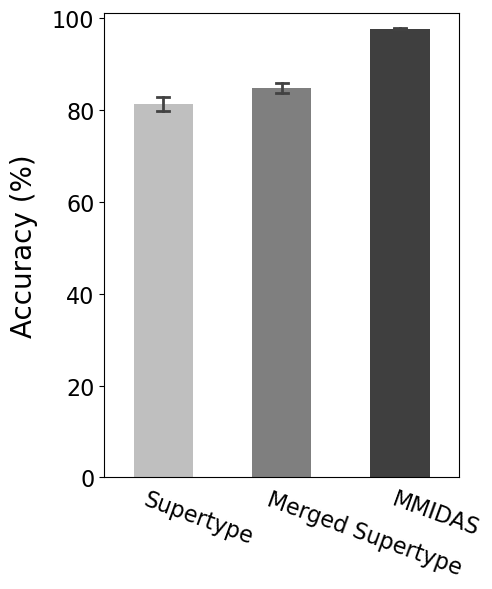

In [46]:
acc_Ttype = np.array(acc_T_lowD[0]) * 100
acc_merg_Ttype = np.array(acc_merged_T_lowD[0]) * 100
acc_cons = np.mean(np.vstack((acc_cons_lowD[0], acc_cons_lowD[1])), axis=0) * 100

df = pd.DataFrame({'Accuracy': np.concatenate((acc_Ttype, acc_merg_Ttype, acc_cons)),
                   'Cell Types': ["Supertype"]*K_fold + ["Merged Supertype"]*K_fold + ["MMIDAS"]*K_fold, 
                   'Arm': ['1']*K_fold + ['1']*K_fold + ['1']*K_fold})

plt.close('all')
fig, ax = plt.subplots(1,1,figsize=[5,6])
sns.reset_defaults()
sns.barplot(data=df, x='Cell Types',y='Accuracy', ax=ax, width=.5, errorbar="sd", palette="gray_r",
            capsize=.1, errwidth=2) 

handles, labels = ax.get_legend_handles_labels()
# ax.legend(handles[-2:], labels[-2:], title='Arms', loc="lower left", fontsize=12)
ax.set_ylim([0, 101])
fontsize = 20
ax.set_ylabel('Accuracy (%)', fontsize=fontsize, labelpad=10)
ax.set_xlabel('')
ax.set_xticks([0.3, 1.7, 2.3])
ax.set_xticklabels(["Supertype", "Merged Supertype", "MMIDAS"])
ax.xaxis.set_tick_params(labelsize=fontsize - 4)
ax.yaxis.set_tick_params(labelsize=fontsize - 4)
ax.xaxis.set_ticks_position('none') 

for item in ax.get_xticklabels():
    item.set_rotation(-20)

ax.grid(False) 
fig.tight_layout()
fig.savefig(saving_folder + f'/classAcc_RF_K_{model_order}.png', dpi=600, bbox_inches='tight')
plt.show()

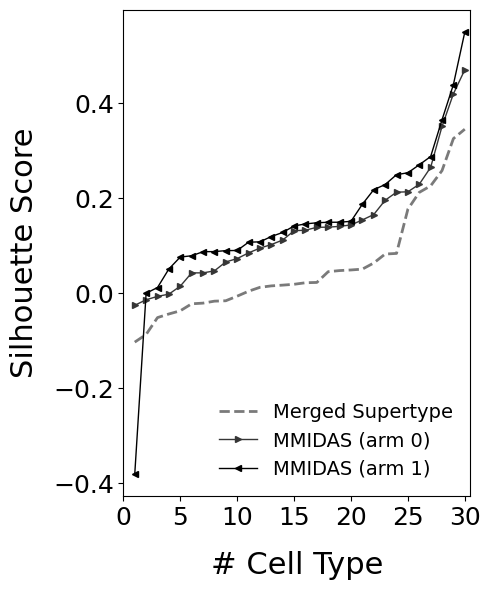

In [52]:
plt.close('all')
plt.figure(figsize=[5, 6], dpi=100)
clrs = ['#363636', 'black']
mks = ['>', '<']
plt.plot(np.arange(model_order)+1, np.sort(sc_mergT_lowD[0]), linewidth=2, linestyle='--', 
         label='Merged Supertype', color='#7A7A7A')
for arm in range(n_arm):
    plt.plot(np.arange(model_order)+1, np.sort(sc_cons_lowD[arm]), linewidth=1, marker=mks[arm], 
             markersize=4, label=f'MMIDAS (arm {arm})', color=clrs[arm])

fontsize = 22
plt.xlabel('# Cell Type', fontsize=fontsize, labelpad=15)
plt.xticks(fontsize=fontsize - 4)
plt.ylabel('Silhouette Score', fontsize=fontsize, labelpad=10)
plt.yticks(fontsize=fontsize - 4)
# plt.ylim([-1, 1])
plt.xlim([0, model_order+0.5])
plt.legend(fontsize=14, loc="lower right", frameon=False)
plt.tight_layout()
plt.savefig(saving_folder + f'/SC_K_{model_order}.png', dpi=600, bbox_inches='tight')
plt.show()

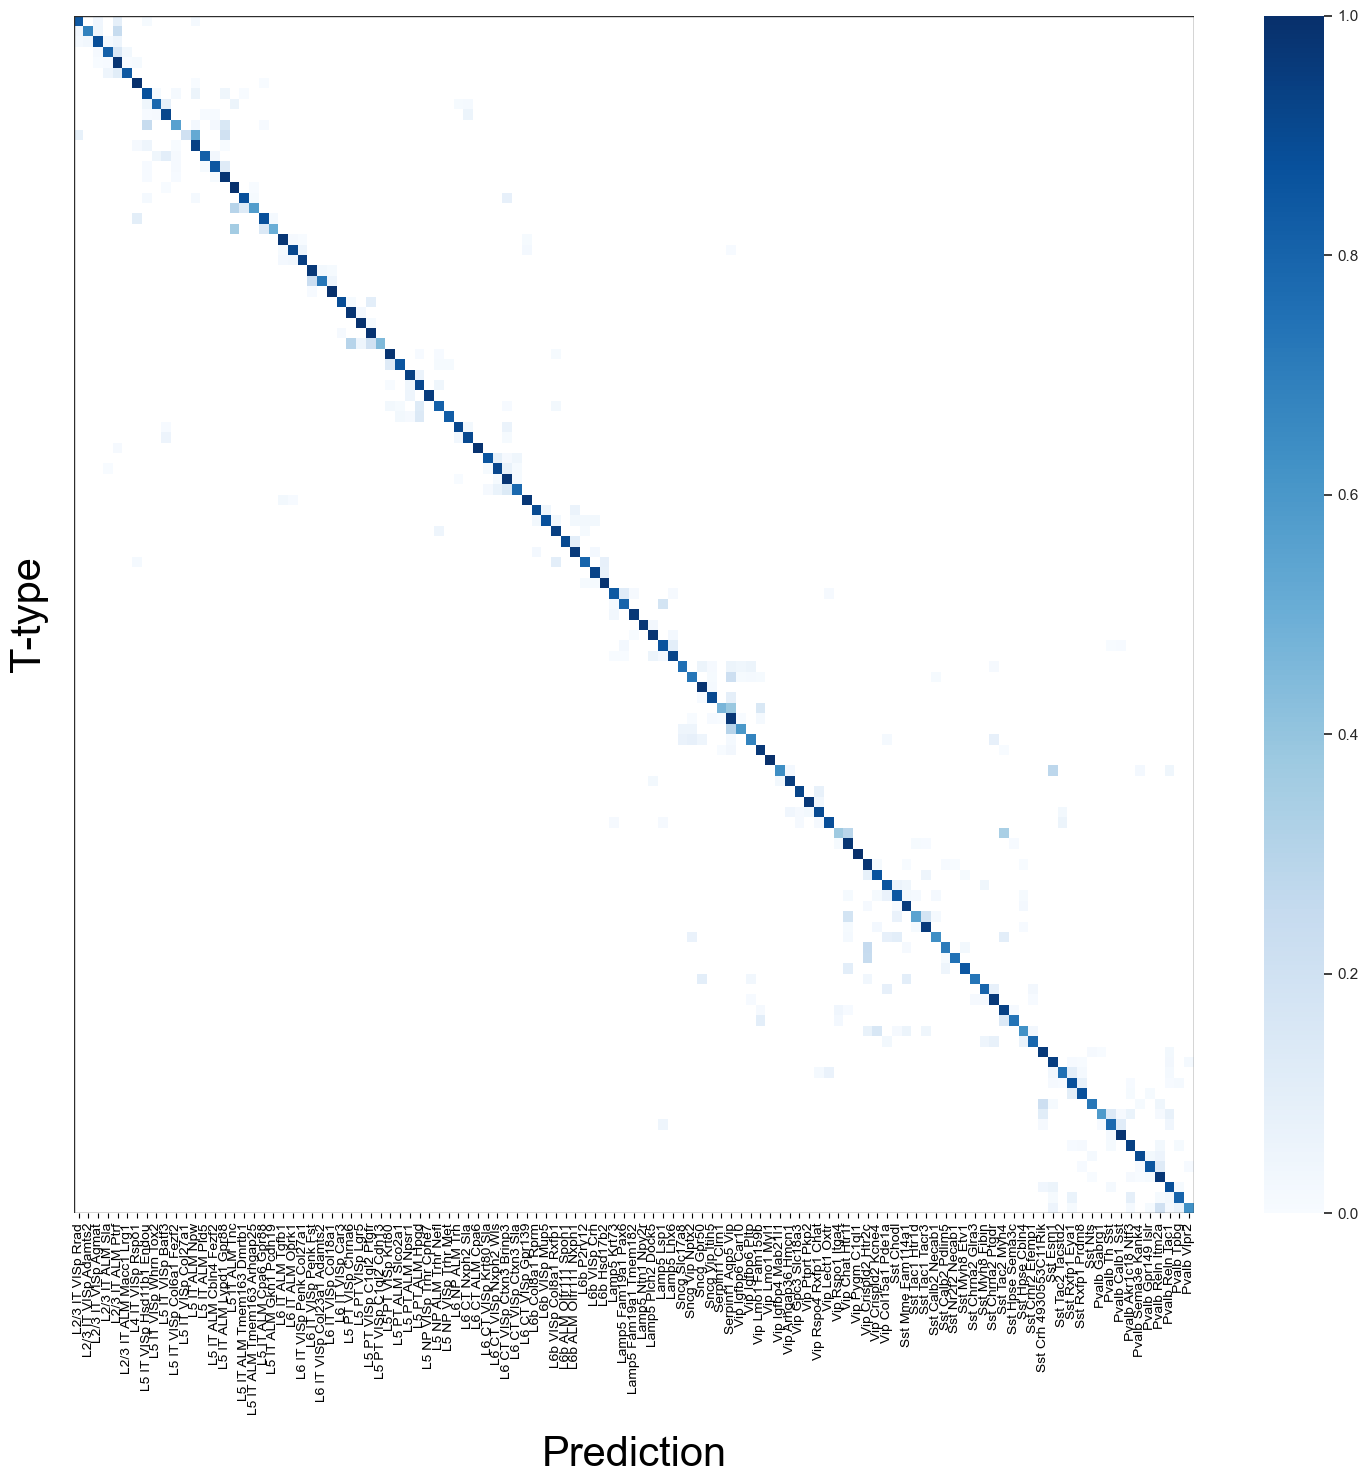

In [14]:
eps = 1e-3
plt.close('all')
fig, axs = plt.subplots(1, 1, figsize=(15, 15))
sns.set(font_scale=1.)
conf_T_pc[conf_T_pc < eps] = 0.
mat = conf_T_pc
sns.set_theme()
sns.set(rc={'axes.facecolor':'white'})
sns.heatmap(mat, xticklabels=T_class_ord, yticklabels=[], vmin=0, vmax=1, ax=axs, cmap='Blues', 
            cbar_kws={"shrink": 1}, mask=(mat==0))
axs.set_ylabel('T-type', fontsize=30, labelpad=15)
axs.set_xlabel('Prediction', fontsize=30, labelpad=15)
axs.set_yticklabels(axs.get_yticklabels())
axs.axhline(y=0, color='#2d2d2d',linewidth=1)
axs.axhline(y=mat.shape[0], color='#2d2d2d',linewidth=1)
axs.axvline(x=0, color='#2d2d2d',linewidth=1)
axs.axvline(x=mat.shape[1], color='#2d2d2d',linewidth=1)
fig.tight_layout()
fig.savefig(saving_folder + f'/conf_Ttype_pc.png', dpi=1000, bbox_inches='tight')
plt.show()

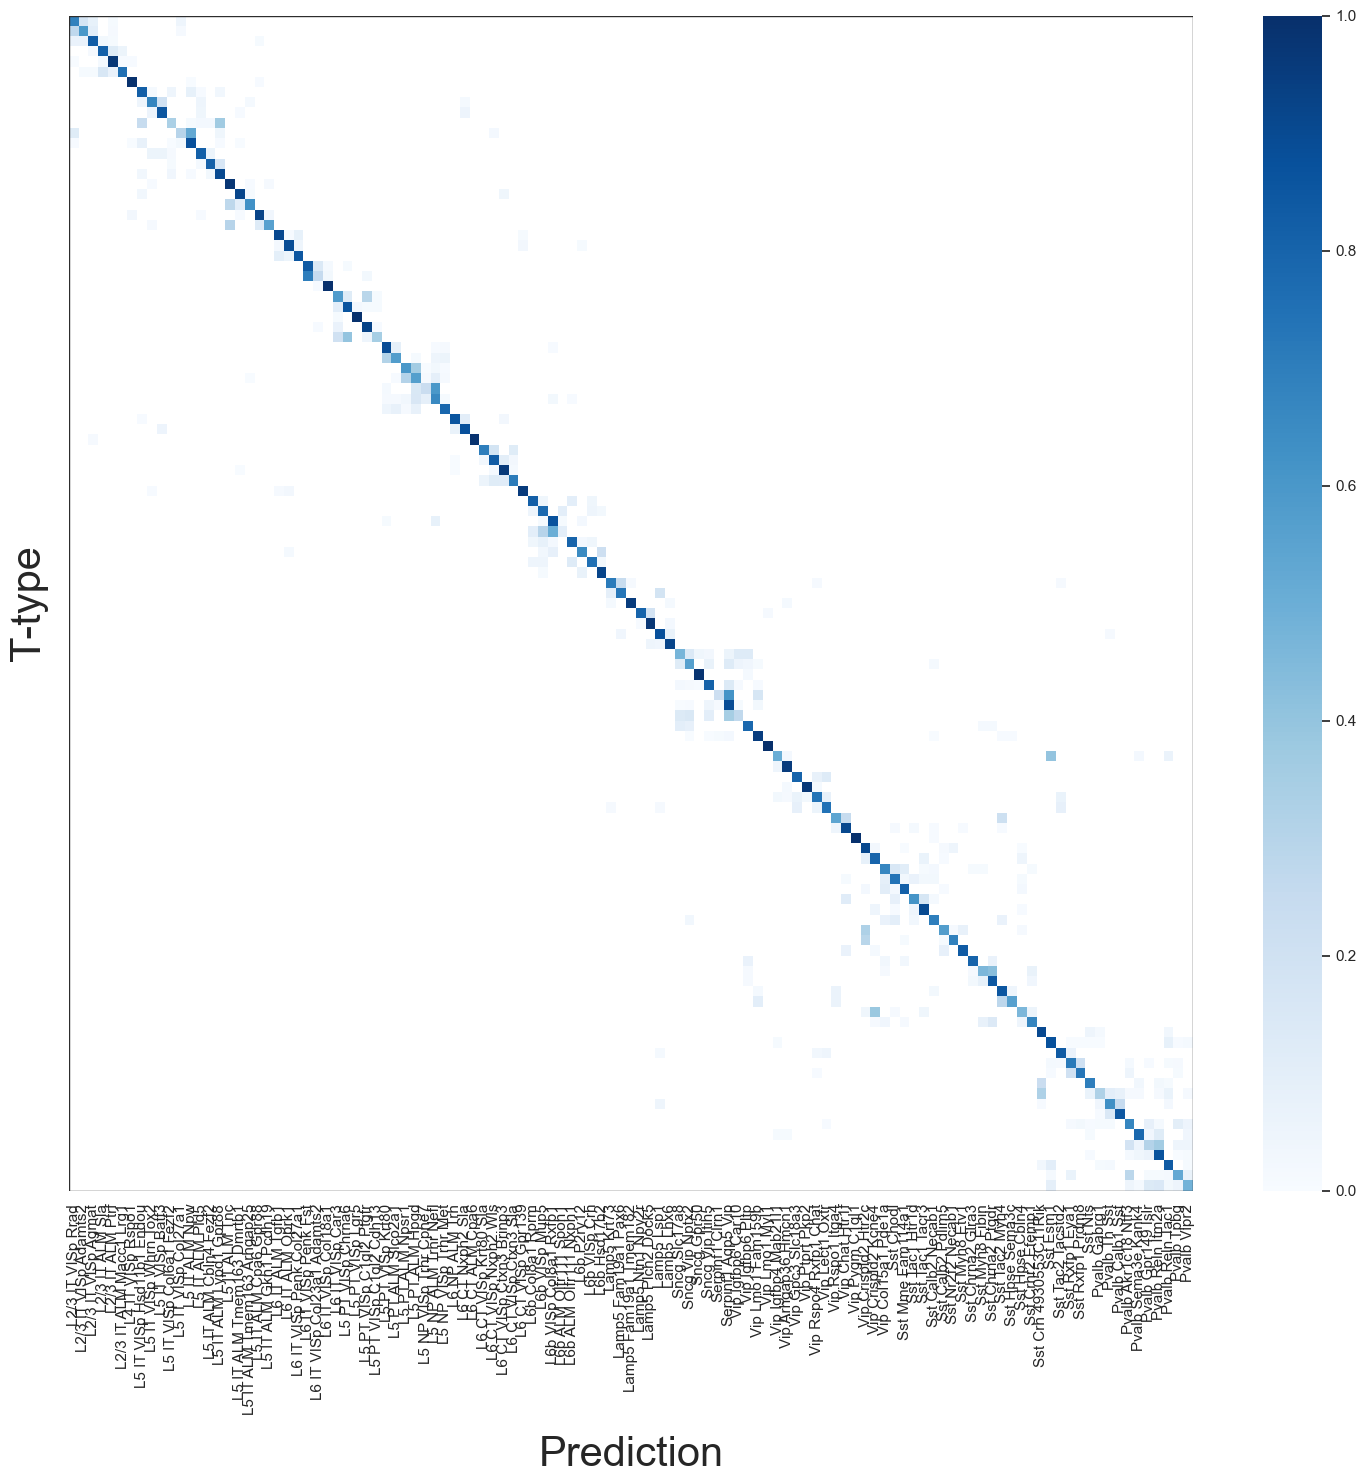

In [15]:
eps = 1e-3
plt.close('all')
fig, axs = plt.subplots(1, 1, figsize=(15, 15))
sns.set(font_scale=1.)
mat = conf_T_lowD[0]
mat[mat < eps] = 0.
sns.set_theme()
sns.set(rc={'axes.facecolor':'white'})
sns.heatmap(mat, xticklabels=T_class_ord, yticklabels=[], vmin=0, vmax=1, ax=axs, cmap='Blues', 
            cbar_kws={"shrink": 1}, mask=(mat==0))
axs.set_ylabel('T-type', fontsize=30, labelpad=15)
axs.set_xlabel('Prediction', fontsize=30, labelpad=15)
axs.set_yticklabels(axs.get_yticklabels())
axs.axhline(y=0, color='#2d2d2d',linewidth=1)
axs.axhline(y=mat.shape[0], color='#2d2d2d',linewidth=1)
axs.axvline(x=0, color='#2d2d2d',linewidth=1)
axs.axvline(x=mat.shape[1], color='#2d2d2d',linewidth=1)
fig.tight_layout()
fig.savefig(saving_folder + f'/conf_Ttype_lowD.png', dpi=1000, bbox_inches='tight')
plt.show()

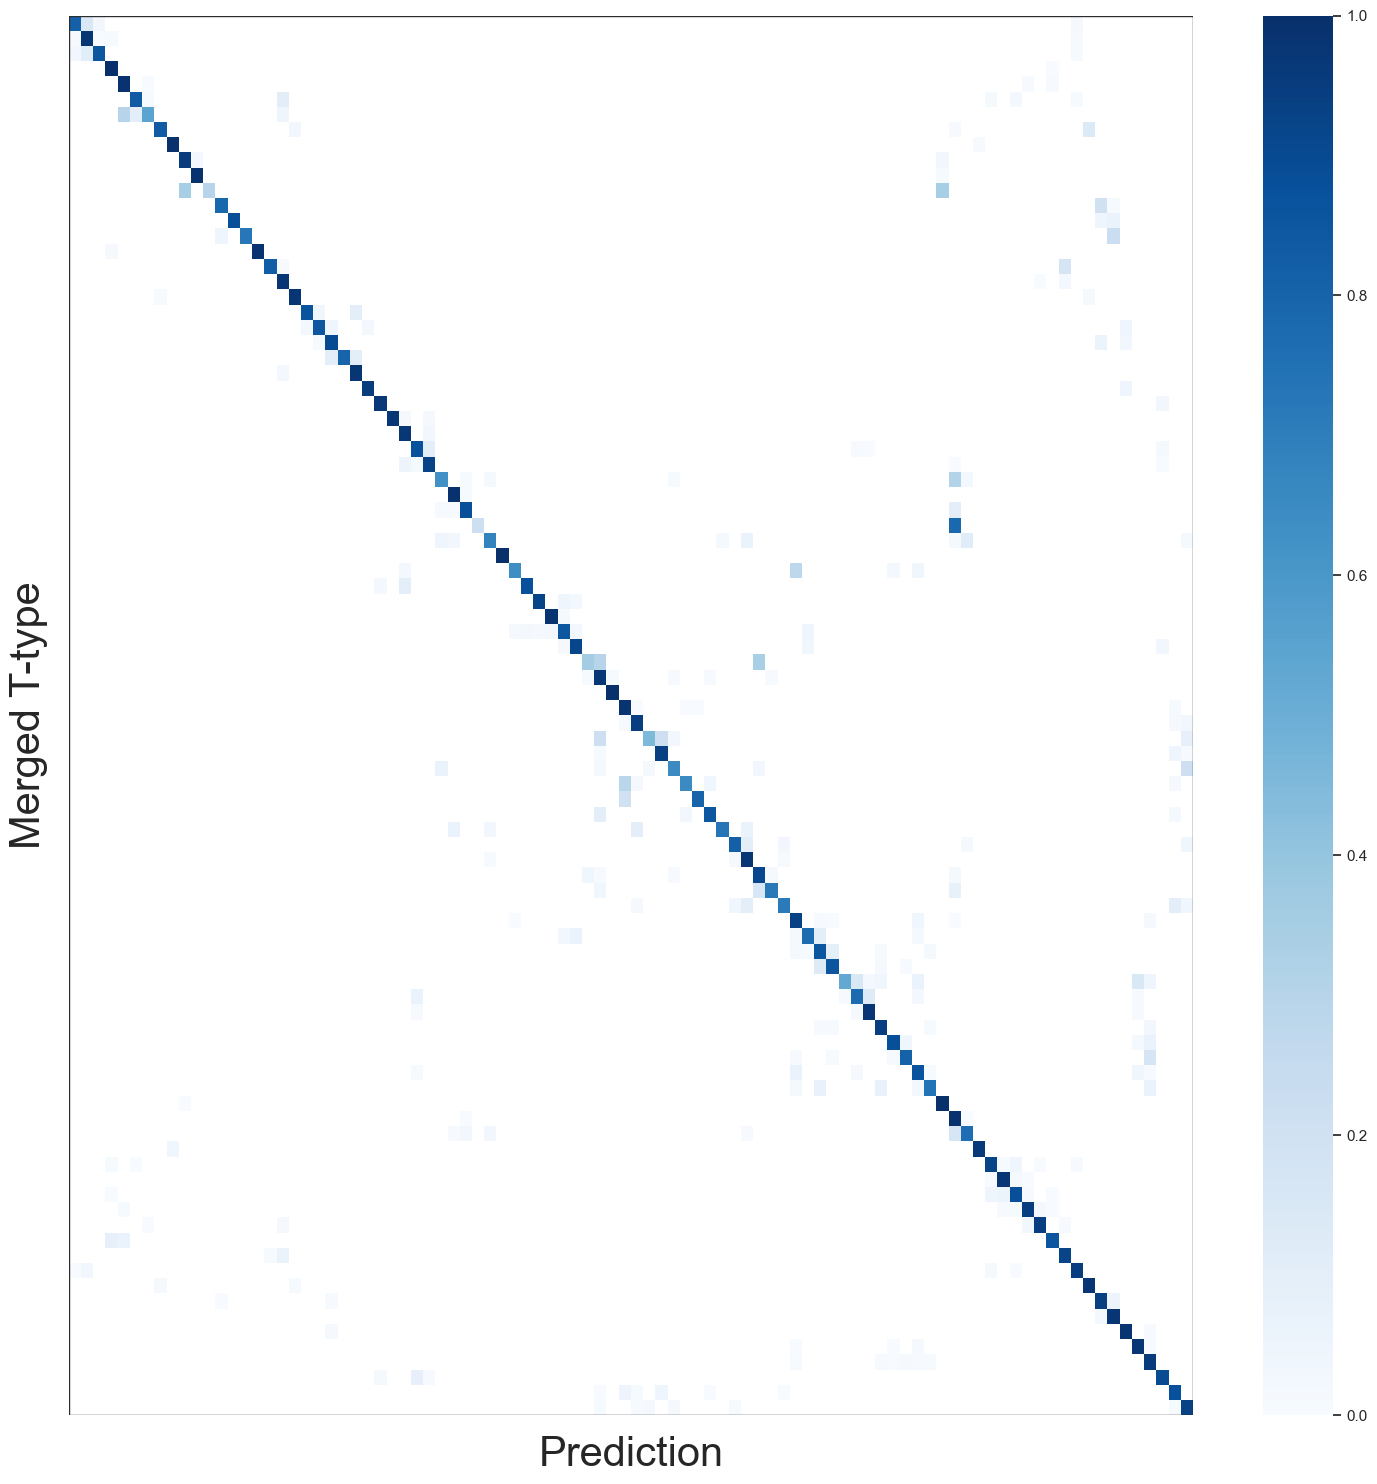

In [16]:
eps = 1e-3
plt.close('all')
fig, axs = plt.subplots(1, 1, figsize=(15, 15))
sns.set(font_scale=1.)
conf_mergT_pc[conf_mergT_pc < eps] = 0.
mat = conf_mergT_pc
sns.set_theme()
sns.set(rc={'axes.facecolor':'white'})
sns.heatmap(mat, xticklabels=[], yticklabels=[], vmin=0, vmax=1, ax=axs, cmap='Blues', 
            cbar_kws={"shrink": 1}, mask=(mat==0))
axs.set_ylabel('Merged T-type', fontsize=30, labelpad=15)
axs.set_xlabel('Prediction', fontsize=30, labelpad=15)
axs.set_yticklabels(axs.get_yticklabels())
axs.axhline(y=0, color='#2d2d2d',linewidth=1)
axs.axhline(y=mat.shape[0], color='#2d2d2d',linewidth=1)
axs.axvline(x=0, color='#2d2d2d',linewidth=1)
axs.axvline(x=mat.shape[1], color='#2d2d2d',linewidth=1)
fig.tight_layout()
fig.savefig(saving_folder + f'/conf_merged_Ttype_pc.png', dpi=1000, bbox_inches='tight')
plt.show()

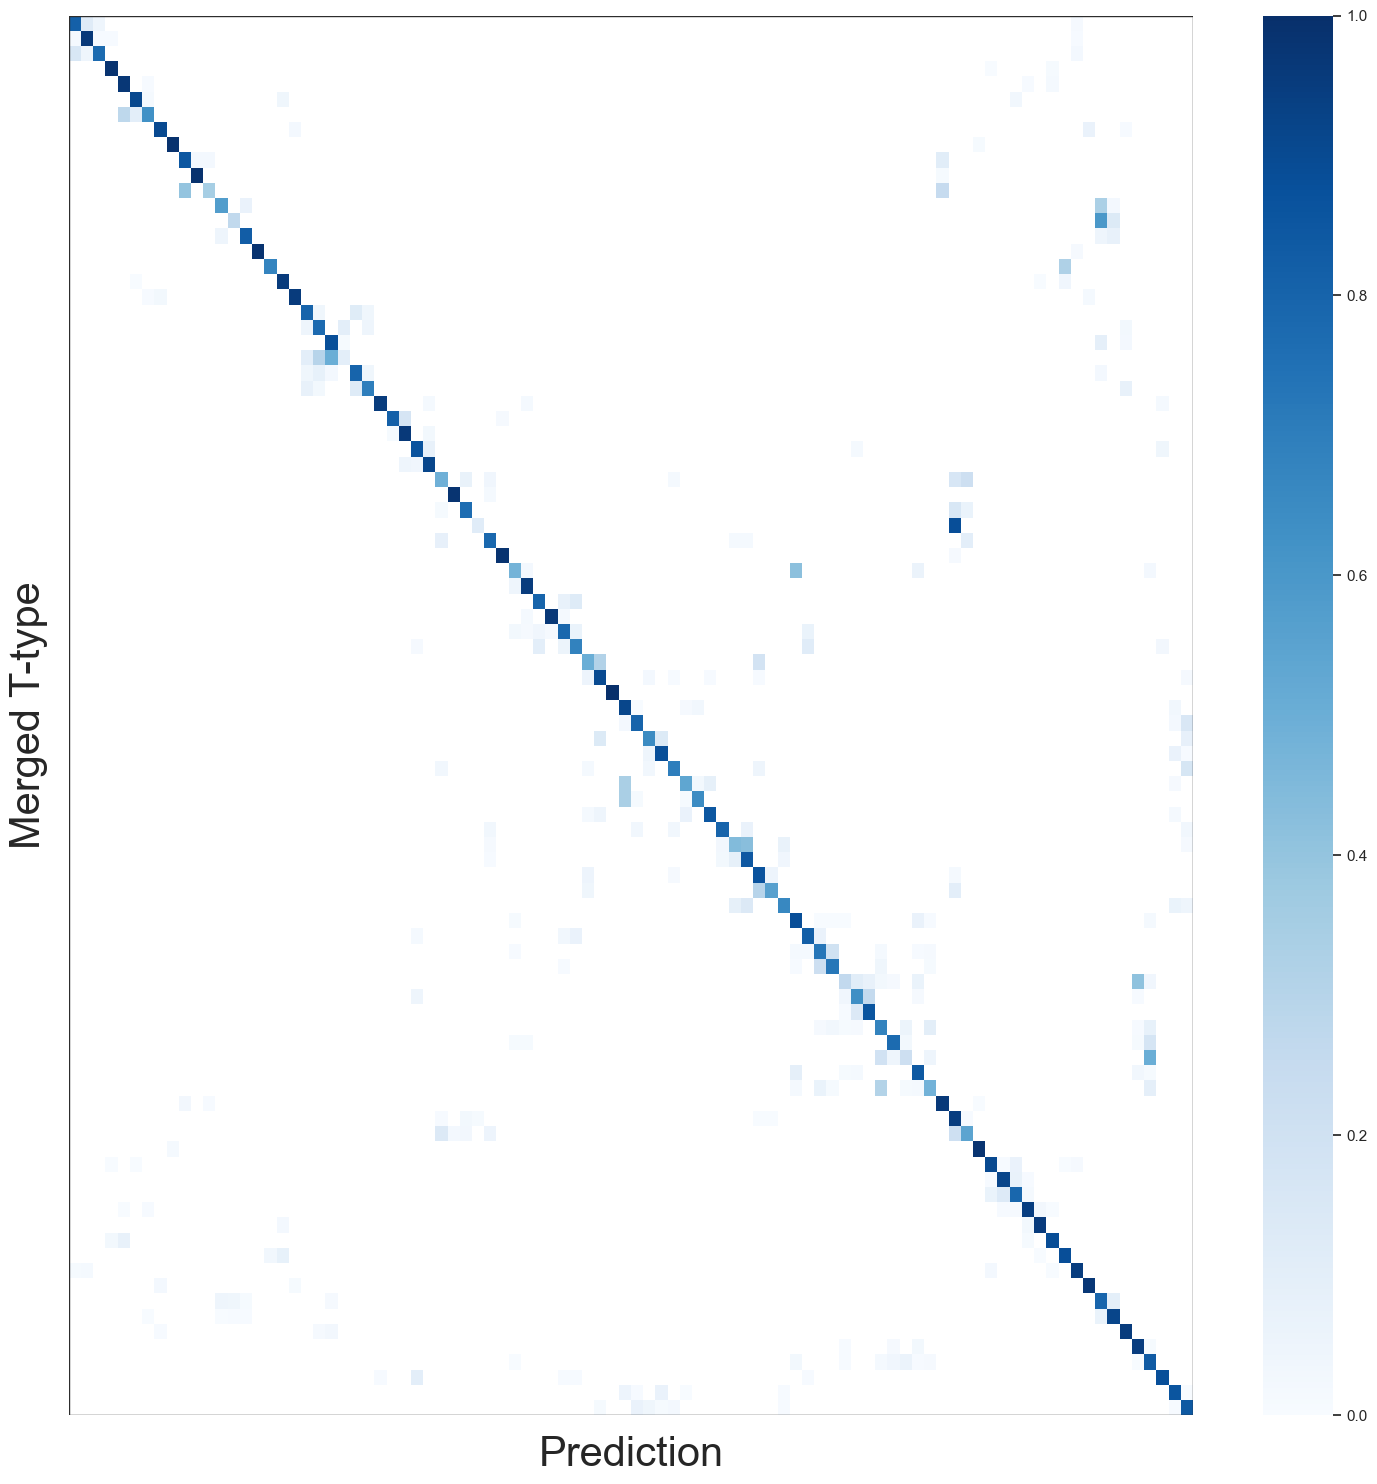

In [17]:
eps = 1e-3
plt.close('all')
fig, axs = plt.subplots(1, 1, figsize=(15, 15))
mat = conf_mergT_lowD[0]
mat[mat < eps] = 0.
sns.set(font_scale=1.)
sns.set_theme()
sns.set(rc={'axes.facecolor':'white'})
sns.heatmap(mat, xticklabels=[], yticklabels=[], vmin=0, vmax=1, ax=axs, cmap='Blues', 
            cbar_kws={"shrink": 1}, mask=(mat==0))
axs.set_ylabel('Merged T-type', fontsize=30, labelpad=15)
axs.set_xlabel('Prediction', fontsize=30, labelpad=15)
axs.set_yticklabels(axs.get_yticklabels())
axs.axhline(y=0, color='#2d2d2d',linewidth=1)
axs.axhline(y=mat.shape[0], color='#2d2d2d',linewidth=1)
axs.axvline(x=0, color='#2d2d2d',linewidth=1)
axs.axvline(x=mat.shape[1], color='#2d2d2d',linewidth=1)
fig.tight_layout()
fig.savefig(saving_folder + f'/conf_merged_Ttype_lowD.png', dpi=1000, bbox_inches='tight')
plt.show()

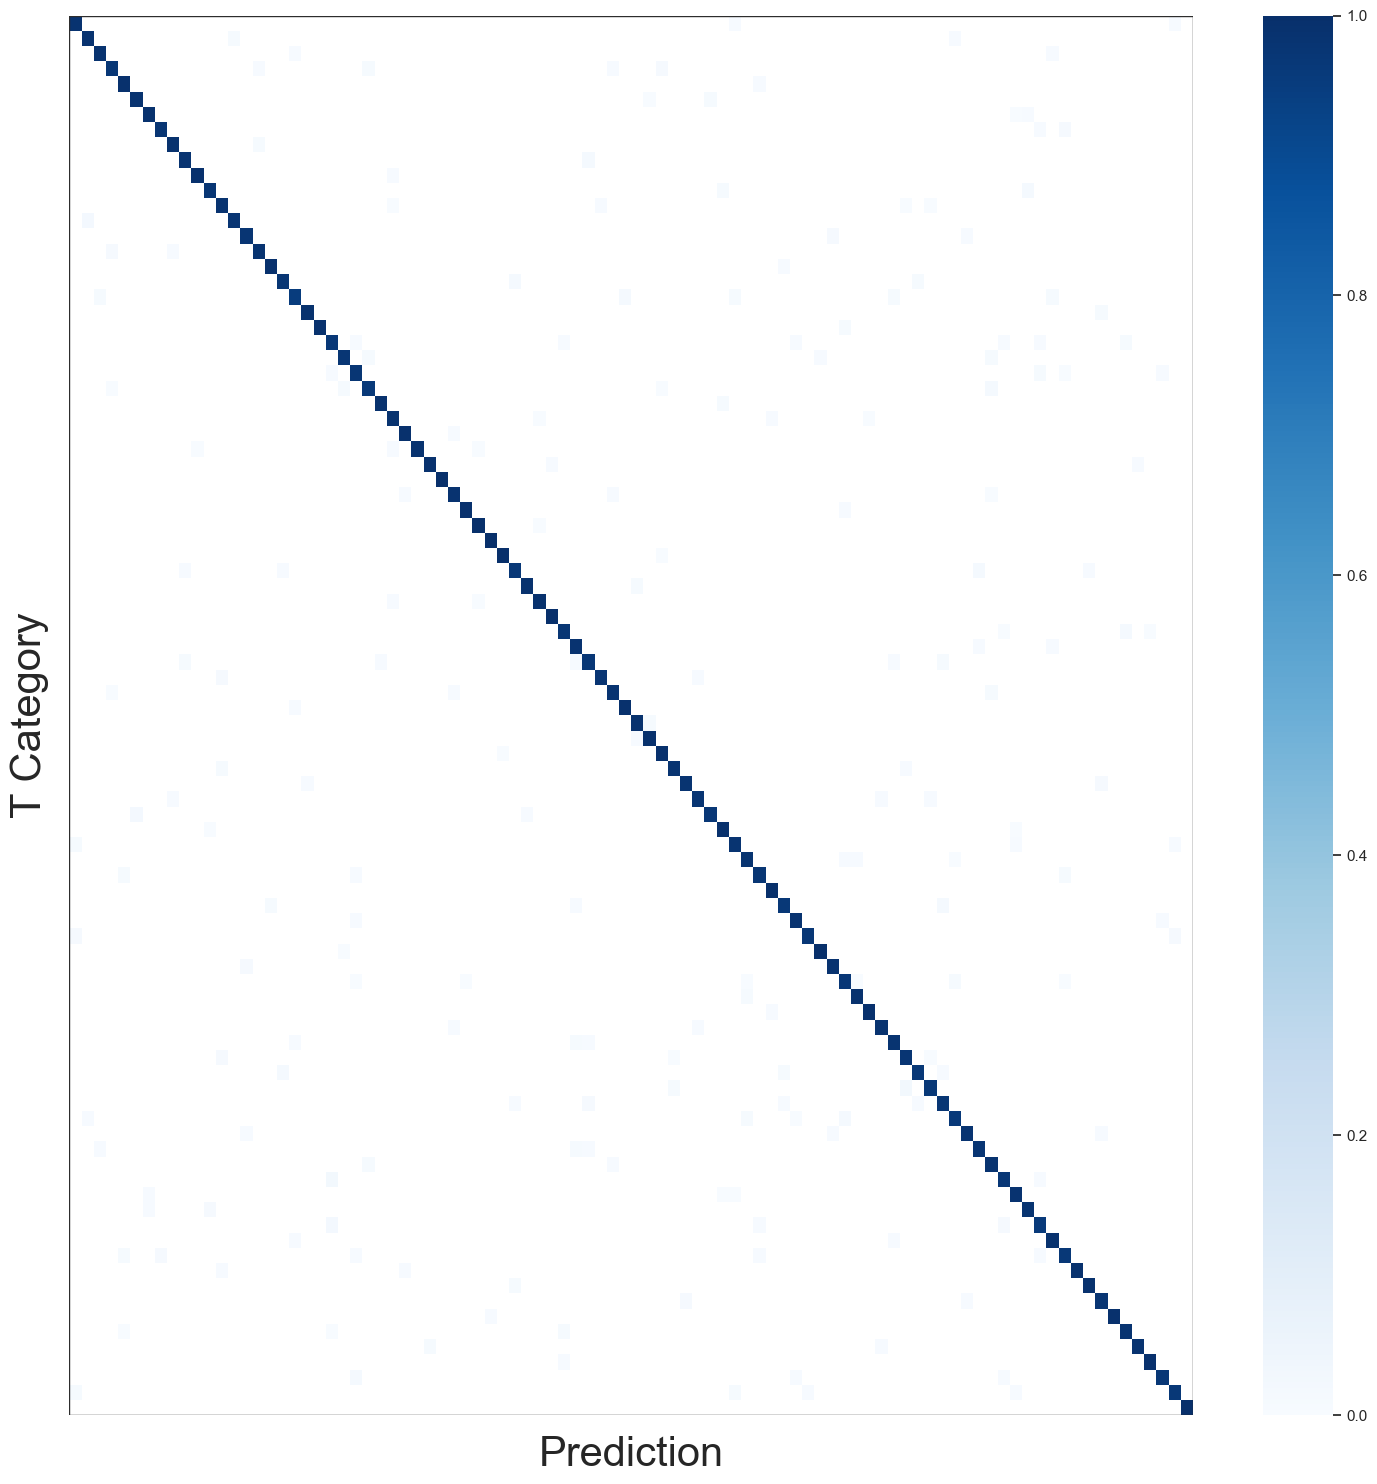

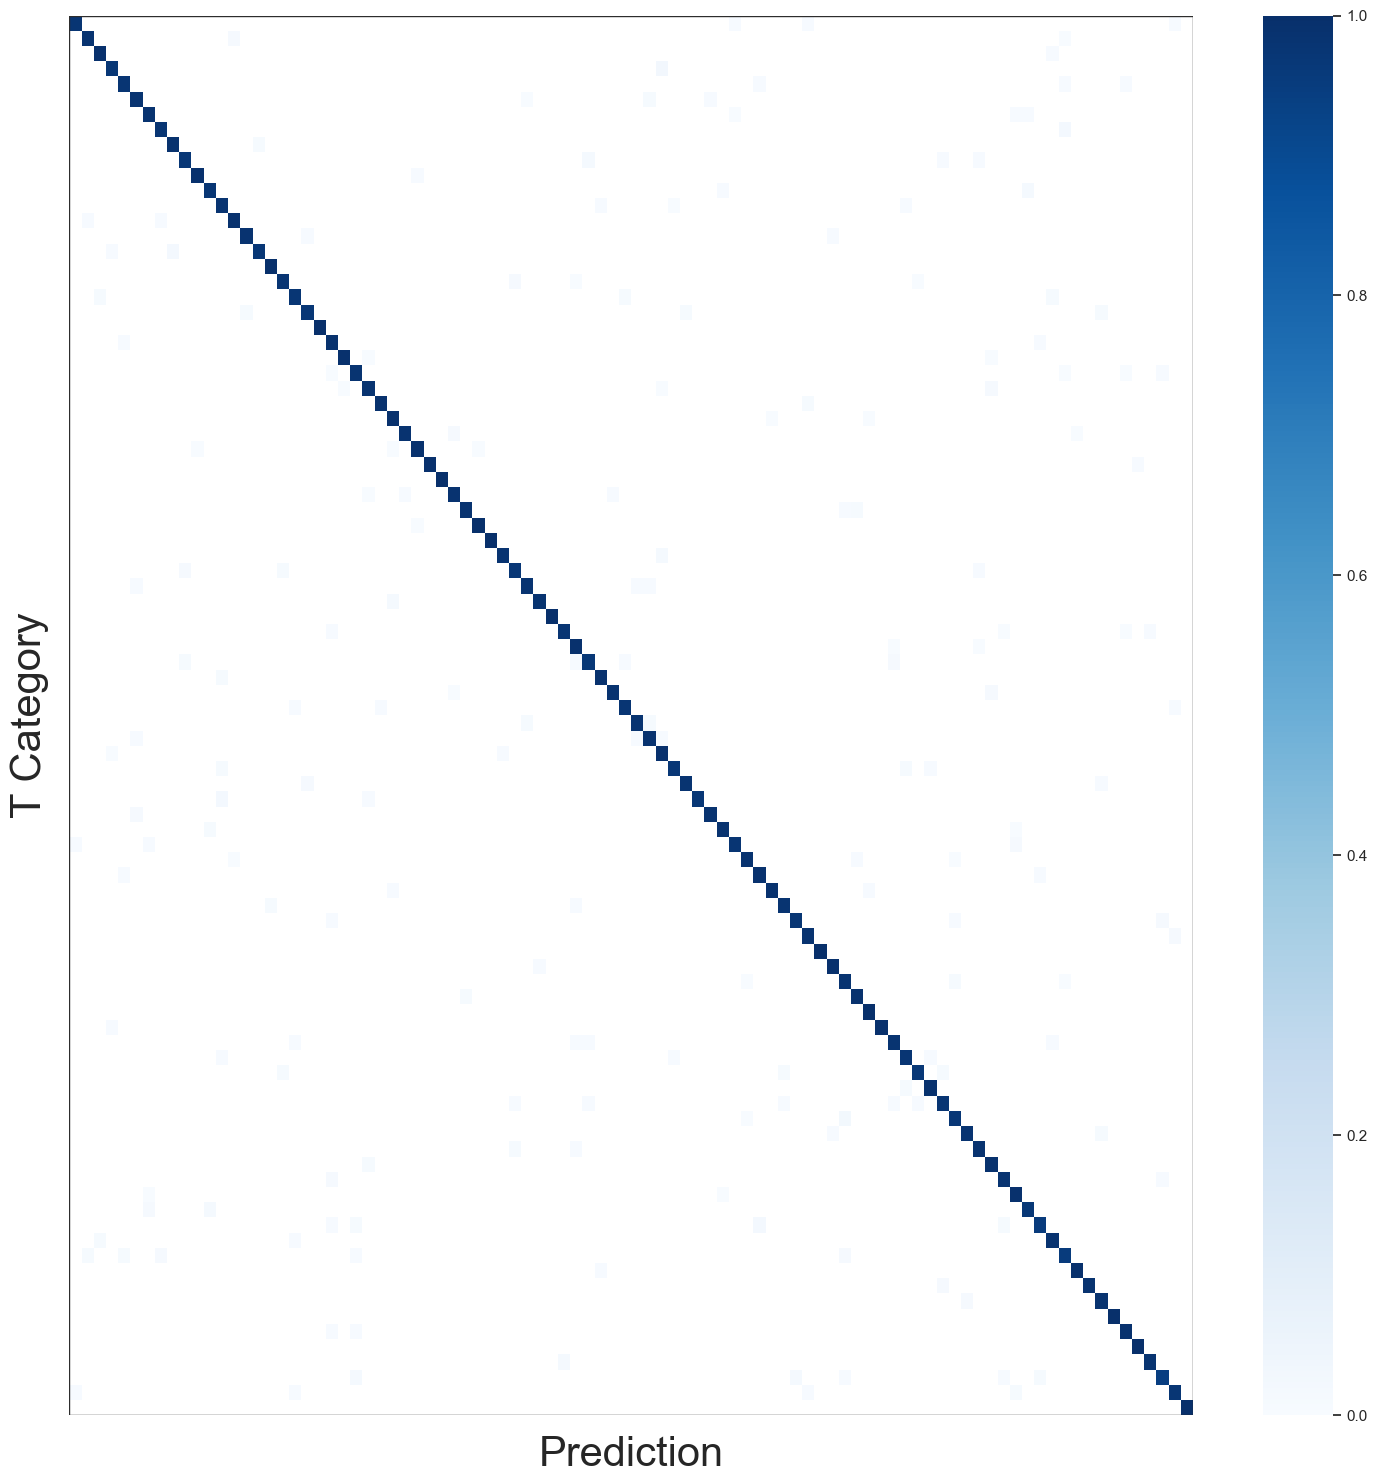

In [18]:
for arm in range(n_arm):
    plt.close('all')
    fig, axs = plt.subplots(1, 1, figsize=(15, 15))
    sns.set(font_scale=1.)
    mat = conf_cons_lowD[arm]
    mat[mat < eps]= 0.
    sns.set_theme()
    sns.set(rc={'axes.facecolor':'white'})
    sns.heatmap(mat, xticklabels=[], yticklabels=[], vmin=0, vmax=1, ax=axs, cmap='Blues', 
                cbar_kws={"shrink": 1}, mask=(mat==0))
    axs.set_ylabel('T Category', fontsize=30, labelpad=15)
    axs.set_xlabel('Prediction', fontsize=30, labelpad=15)
    axs.set_yticklabels(axs.get_yticklabels())
    axs.axhline(y=0, color='#2d2d2d',linewidth=1)
    axs.axhline(y=mat.shape[0], color='#2d2d2d',linewidth=1)
    axs.axvline(x=0, color='#2d2d2d',linewidth=1)
    axs.axvline(x=mat.shape[1], color='#2d2d2d',linewidth=1)
    fig.tight_layout()
    fig.savefig(saving_folder + f'/conf_cons_T_lowD_arm_{arm}.png', dpi=1000, bbox_inches='tight')
    plt.show()

In [19]:
treeobj.plot(figsize=[30,10], save=True, path=saving_folder, skeletoncol='gray')

/Users/yeganeh.marghi/miniconda3/envs/tf14-cpu/lib/python3.7/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


In [20]:
treeobj_1.plot(figsize=[30,10], save=True, path=saving_folder, skeletoncol='gray')